In [422]:
import networkx as nx
import pandas as pd
from functools import wraps
from datetime import datetime, timedelta
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [358]:
# 显示一个函数的运行时间
def show_running_time(func):
    @wraps(func)
    def _show_time(*args, **kwargs):
        now = datetime.now()
        result = func(*args, **kwargs)
        print(func.__name__, datetime.now() - now)
        return result
    return _show_time

In [359]:
MAIN_PATH = "/Users/v_liliting/Documents/董监高关系"

In [442]:
# 递归，获取path下所有xlsx文件存储地址
def get_paths(path, path_list=()):
    path_list = list(path_list)
    for ele in os.listdir(path):
        ele_path = path + "/" + ele
        if os.path.isfile(ele_path) and ele_path.endswith("xlsx"):
            path_list.append(ele_path)
        elif os.path.isdir(ele_path):
# 这里一定要写上path_list=path_list, 否则会重置为空列表
            get_paths(ele_path, path_list=path_list)
    return path_list


# os.walk
# os有os.walk方法可以遍历path下的文件夹，可以不用dir
# def get_paths(path):
#     for path, _, _ in os.walk(path):
#         for filename in os.listdir(path):
#             pass

In [445]:
# 按照四个文件夹读取关系列表，存为dict文件
def get_relation_paths_dict(main_path, relation_type=("亲戚关系", "企业关系", "政府关系", "校友关系")):
    all_path_dict = {}
    for relation in relation_type:
        relation_path_list = []
        all_path_dict[relation] = get_paths(main_path+"/"+relation, relation_path_list)
    return all_path_dict

In [446]:
# 运行的时候，如果不传入新的参数空列表， 就会在path_list里面不断的存入新的path
# a = get_paths("/Users/v_liliting/Documents/董监高关系/企业关系", [])

In [447]:
# @show_running_time
def get_crisis_data(path):
    crisis_data = pd.read_excel(path, parse_dates=["披露日期"])
    print("crisis_data is loading successfully")
    print(crisis_data.shape)
    print(crisis_data.head())
    print(crisis_data.dtypes)
    print("============done!=============")
    return crisis_data

In [364]:
crisis_data = get_crisis_data("/Users/v_liliting/Documents/危机事件+代码/选择危机事件并划分种类.xlsx")

crisis_data is loading successfully
(796, 10)
          证券代码   证券名称 证券类型  事件大类    事件类型      发生日期  事件类型编码 事件梗概  \
312  600397.SH  *ST安煤   股票  经营事件      停产  20161124     NaN  NaN   
14   600408.SH  *ST安泰   股票  红色预警  违规行为公告  20150724     5.0  NaN   
167  600408.SH  *ST安泰   股票  红色预警  违规行为公告  20160421     5.0  NaN   
631  600408.SH  *ST安泰   股票  红色预警  违规行为公告  20171214     5.0  NaN   
738  002188.SZ  *ST巴士   股票  红色预警  立案调查开始  20180426     NaN  NaN   

                                                  事件摘要       披露日期  
312  根据《江西省化解过剩产能领导小组办公室关于做好调整2016年度煤矿关闭退出计划的紧急通知》要... 2016-11-25  
14   因未及时披露公司重大事项,未依法履行其他职责，上海证券交易所于2015-07-24依据相关法... 2015-07-24  
167  因未及时披露公司重大事项，中国证券监督管理委员会于2016-04-20依据相关法规给予:公开... 2016-04-21  
631  因未及时披露公司重大事项,未依法履行其他职责，上海证券交易所于2017-12-13依据相关法... 2017-12-14  
738  中国证券监督管理委员会对公司巴士在线股份有限公司(以下简称 “公司” )于 2018 年 4... 2018-04-27  
证券代码              object
证券名称              object
证券类型              object
事件大类              object
事件类型              object
发生日期              

In [443]:
# 处理股票代码
def padding(Symbol):
    text = str(Symbol)
#     补0，也可以用'{name:0>10}'.format(name="heyao")
    new_text = text.zfill(6)
    if new_text.startswith("0"):
        new_text = new_text + ".SZ"
    if new_text.startswith("6"):
        new_text = new_text + ".SH"
    return new_text
# padding(6)

In [367]:
# 读取单个文件
@show_running_time
def get_data(path, padding=padding):
    relation_relatives = pd.read_excel(path, skiprows=[1,2])
    relation_relatives["EndDate"] = pd.to_datetime(relation_relatives.EndDate)
    relation_relatives["Symbol"] = relation_relatives.Symbol.map(padding)
    return relation_relatives

In [368]:
# relation_government = get_data(path=paths["government"])
# relation_relative = get_data(path=paths["relatives"])

In [369]:
# 根据paths_dict，按照关系类别存为一个dict。
@show_running_time
def get_all_relation_data(paths_dict):
    relation_df_dict = {}
    for relation_type, path_list in paths_dict.items():
        print(relation_type)
        relation_df = pd.DataFrame()
        for path in path_list:
            print("start now!", path)
            t1 = datetime.now()
            relation_df = pd.concat([relation_df, get_data(path)], axis=0)
            print(datetime.now() - t1)
        relation_df_dict[relation_type] = relation_df
    return relation_df_dict

In [427]:
# 构造网络之前，筛选时间和股票代码,暂时筛选year和code
def relation_data_preprocessing(data, year, crisis_data, relation_type):
    valid_code = set(crisis_data["证券代码"].values)
    data["EndDate"] = data.EndDate.map(lambda x: x[:4])
    new_data = data[(data["Symbol"].isin(valid_code)) & (data["EndDate"] == year)]
    new_data["person1"] = new_data.PersonID.map(str) + "_" + new_data.Symbol

# 企业关系和其他关系的表存在不同
    if relation_type == "企业关系":
        new_data["person2_list"] = new_data.RltPersonID.map(str) + "_" + new_data.Stkcd_OtherCo
    return new_data

In [439]:
# 构建关系list
def construct(relation_type, year, crisis_data):
    new_data = relation_data_preprocessing(relation_df_dict[relation_type], year, crisis_data, relation_type)
#     print(new_data.head())
    relation_list = []
#  企业关系的通过id+code来
    if relation_type == "企业关系":
        for i in new_data.index:
            person1 = new_data.loc[i, "person1"]
            person2_all = new_data.loc[i, "person2_list"]
            try:
                person2_id = person2_all.split("_")[0]
        #         print(person2_id)
                person2_codes = person2_all.split("_")[1]

                if ";" in person2_codes:
                    person2_code_all = person2_all.split("_")[1].split(";")
                    for i in person2_code_all:
                        person2_code = padding(i)
                        relation_list.append((person1,person2_id+"_"+person2_code))
                else:
                    person2_code = padding(person2_all.split("_")[1])
                    relation_list.append((person1,person2_id+"_"+person2_code))
            except AttributeError:
                continue
        relation_df = pd.DataFrame(relation_list, columns=["person1", "person2"])
# 其他关系，危机事件公司人员为id+code，关联人员为id 
    else:
        relation_df = new_data.loc[:, ["person1", "RltPersonID"]]
        relation_df.columns = ["person1", "person2"]
        return relation_df

In [440]:
# 画图，没有改这个函数
def draw(G, *args):
    # Draw the graph using the random layout
    plt.figure(figsize=(10,9))
    pos = nx.random_layout(G)
    nx.draw_networkx(G, pos,with_labels=False,node_size=10)
    plt.savefig(*args)

In [437]:
# 读入数据后的执行函数
def main(crisis_data, relation_type, year):
    save_name = relation_type + year
    print(save_name)
    relation_df = construct(crisis_data=crisis_data, year="2015", relation_type="亲戚关系")
    G = nx.from_pandas_edgelist(relation_df, source="person1", target="person2")
    draw(G, save_name+".png")
    nx.write_gexf(G, save_name+'.gexf')
    print(save_name, "done!")

In [441]:
def cal_indicators(network):
    pass

# main函数部分

In [432]:
# 按照关系类别获取文件夹下所有的xlsx文件
path_dict = get_relation_paths_dict(MAIN_PATH)
path_dict

{'亲戚关系': ['/Users/v_liliting/Documents/董监高关系/亲戚关系/TMT_Relatives12-17.xlsx'],
 '企业关系': ['/Users/v_liliting/Documents/董监高关系/企业关系/TMT_Colleagues12-15.xlsx',
  '/Users/v_liliting/Documents/董监高关系/企业关系/TMT_Colleagues16-17.xlsx'],
 '政府关系': ['/Users/v_liliting/Documents/董监高关系/政府关系/TMT_FGORelation12-17.xlsx'],
 '校友关系': ['/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表15/TMT_Alumni.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表15/TMT_Alumni1.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni1.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni2.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni3.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表17/TMT_Alumni.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表17/TMT_Alumni1.xlsx',
  '/Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表17/TMT_Alumni2.xlsx']

In [371]:
# 读数据大约需要1个小时，建议用csv或txt存，最好csv，excel太慢了
relation_df_dict = get_all_relation_data(paths_dict=path_dict)

政府关系
start now! /Users/v_liliting/Documents/董监高关系/政府关系/TMT_FGORelation12-17.xlsx
get_data 0:02:41.095860
0:02:41.404560
校友关系
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表15/TMT_Alumni.xlsx
get_data 0:05:26.319846
0:05:26.835119
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表15/TMT_Alumni1.xlsx
get_data 0:04:22.623221
0:04:23.982849
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni.xlsx
get_data 0:05:45.969238
0:05:48.426586
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni1.xlsx
get_data 0:05:23.989512
0:05:26.909865
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni2.xlsx
get_data 0:05:23.411401
0:05:27.917487
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表16/TMT_Alumni3.xlsx
get_data 0:04:21.883124
0:04:26.988581
start now! /Users/v_liliting/Documents/董监高关系/校友关系/董监高校友关系及特征信息表17/TMT_Alumni.xlsx
get_data 0:05:47.339382
0:05:53.959750
start now! /Users/v_lili

亲戚关系2015


/Users/v_liliting/anaconda2/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/v_liliting/anaconda2/envs/tensorflow/lib/python3.5/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


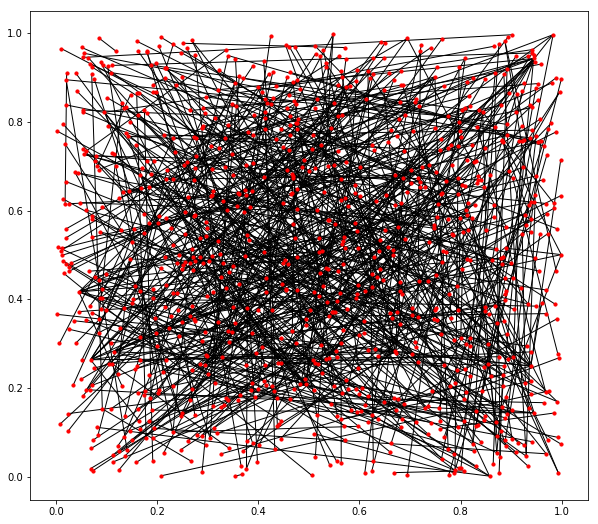

In [438]:
main(crisis_data, "亲戚关系", "2015")